<a href="https://colab.research.google.com/github/quiquefluque/Primera-prueba-/blob/main/Primer_analisis_(TESLA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1024096611.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TSLA', period='1y')
[*********************100%***********************]  1 of 1 completed


                Precio
Date                  
2025-02-14  355.839996
2025-02-18  354.109985
2025-02-19  360.559998
2025-02-20  354.399994
2025-02-21  337.799988
...                ...
2026-02-09  417.320007
2026-02-10  425.209991
2026-02-11  428.269989
2026-02-12  417.070007
2026-02-13  417.440002

[251 rows x 1 columns]
La volatilidad el ultimo año es de 0.038799435155073
La mediad de retornos el ultimo año es de 0.00138703324348739
El precio actual es 417.44000244140625
Sim 0: Ganó la media de 20 días | Win Final: 2.20 | Peor Susto: 21.48%
Para la simulación 0 el maximo drawdown es 0.16543966414625702
Sim 1: Ganó la media de 50 días | Win Final: 1.27 | Peor Susto: 16.54%
Para la simulación 1 el maximo drawdown es 0.2326625713502764
Sim 2: Ganó la media de 50 días | Win Final: 1.41 | Peor Susto: 23.27%
Para la simulación 2 el maximo drawdown es 0.273861817042632
Sim 3: Ganó la media de 20 días | Win Final: 0.94 | Peor Susto: 27.39%
Para la simulación 3 el maximo drawdown es 0.26054447

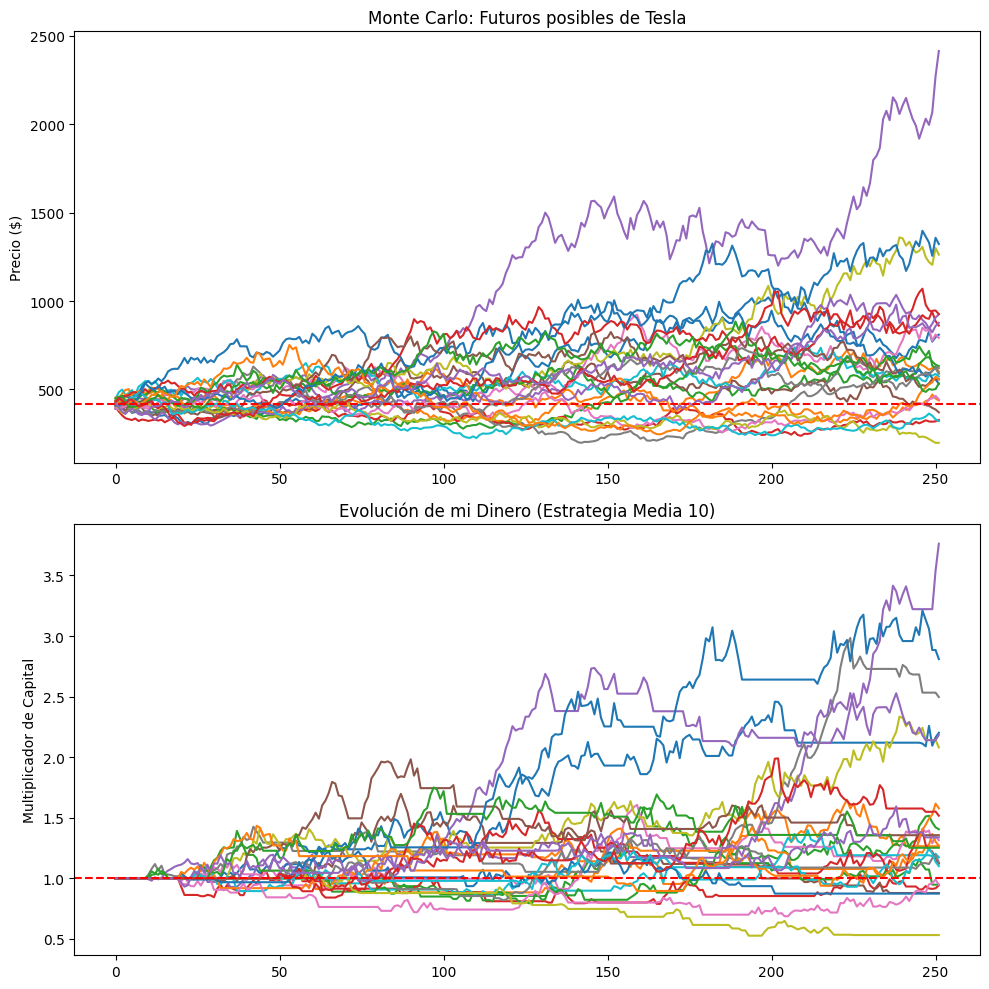

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Bajamos los datos de Tesla (TSLA) del último año
df = yf.download('TSLA', period='1y')

# (A veces yfinance devuelve nombres de columnas complejos, así lo simplificamos,solo al precio de cierre
df = df[['Close']].copy()
df.columns = ['Precio'] #cambiar nombre columna

print(df)

#CALCULOS PASADOS

#calculo retornos
df["Retornosreales"]=df["Precio"].pct_change()
#calculo la volatilidad pasada
vol_pasada = np.std (df["Retornosreales"])
print(f"La volatilidad el ultimo año es de {vol_pasada}")
#calculo la media de retonos pasada
media_pasada = np.mean (df["Retornosreales"])
print(f"La mediad de retornos el ultimo año es de {media_pasada}")

#MONTE CARLO SITUACIONES FUTURAS


# retornos ficticios proximo año
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10)) #2filas de graficos y 1 columna

precio_inicial=df["Precio"].iloc[-1] #ultimo valor de la acción
print(f"El precio actual es {precio_inicial}")
for i in range(25):
  #recortadar que hace de golpe los 252 precios futuros por cada iteracion del bucle con el size
  retornos_simulados = np.random.normal(media_pasada, vol_pasada, size=252)
  multiplicadores=1+retornos_simulados
  preciosanofut= precio_inicial*multiplicadores.cumprod()
  ax1.plot(preciosanofut)

  #BOT en esa situación

  #ver que intervalo para la media gana mas
  medias_a_probar=[10,20,50]
  mejor_win=-1
  mejor_m= 10
  for m in medias_a_probar:
    df_sim = pd.DataFrame(preciosanofut, columns=['PrecioSimulado'])
    df_sim["mediafut"]=df_sim["PrecioSimulado"].rolling(window=m).mean()
    df_sim["ordencompra"]=np.where(df_sim["PrecioSimulado"]>df_sim["mediafut"],1,0)

    ret_robot = df_sim['PrecioSimulado'].pct_change() * df_sim['ordencompra'].shift(1)
    df_sim['Wins'] = (1 + ret_robot.fillna(0)).cumprod()
    resultado_final = df_sim['Wins'].iloc[-1]
    if resultado_final > mejor_win:
            mejor_win = resultado_final
            mejor_m=m
  print(f"Sim {i}: Ganó la media de {mejor_m} días | Win Final: {mejor_win:.2f} | Peor Susto: {maximo_drawdown*100:.2f}%")
  df_sim["mediafut"] = df_sim["PrecioSimulado"].rolling(window=mejor_m).mean()
  df_sim["ordencompra"] = np.where(df_sim["PrecioSimulado"] > df_sim["mediafut"], 1, 0)



  #ahora ejecuto con la media que mas gane
  #si ayer compre gano ese retorno, si no compre no gano nada
  df_sim['RetornoganadoRobot'] = df_sim['PrecioSimulado'].pct_change() * df_sim['ordencompra'].shift(1)
  #acumulacion de dinero empezando con 1 euro
  df_sim['Wins'] = (1 + df_sim['RetornoganadoRobot'].fillna(0)).cumprod()
  ax2.plot(df_sim['Wins'])

  #Drawdown de cada estrategia como de riesgosa es. Habria que mirar como de frecuentes son los grandes drawdowns en cada una pero eso queda para mas adelante. Ojo hacer sobre gancias
  df_sim["ganaciamaximo"]=df_sim['Wins'].cummax()
  df_sim["drawdown"]=(df_sim["ganaciamaximo"]-df_sim['Wins'])/df_sim["ganaciamaximo"]
  maximo_drawdown=df_sim['drawdown'].abs().max()#busco el drawdown maximo para cada simulación
  print(f"Para la simulación {i} el maximo drawdown es {maximo_drawdown}")


#TABLAS
ax1.set_title("Monte Carlo: Futuros posibles de Tesla")
ax1.set_ylabel("Precio ($)")

ax2.set_title("Evolución de mi Dinero (Estrategia Media 10)")
ax2.set_ylabel("Multiplicador de Capital")

ax1.axhline(df["Precio"].iloc[-1], color='red', linestyle='--') # Línea de precio inicia
ax2.axhline(1, color='red', linestyle='--') # Línea de "no ganar ni perder"
plt.tight_layout() # Para que no se amontonen los títulos
plt.show()



















